In [1]:
import keras
#from PIL import Image
from keras import layers
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
#from PIL import Image
from keras.utils import to_categorical
import random
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.cm as cm

In [2]:
model = keras.models.load_model("./model/model_CNN_20240302t2014.h5")

In [3]:
def get_img_array(img_paths,target_size):
    img = keras.utils.load_img(img_paths,target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array,axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

In [4]:
img_path = './23.jpg'
img_array = get_img_array(img_path,target_size=(128,128))


In [5]:
print(img_path)

./23.jpg


In [6]:
preds = model.predict(img_array)
print("insulting", preds[0][1])
print("uninsulting", preds[0][0])

1/1 [==============================] - 0s 304ms/step
insulting 0.47098246
uninsulting 0.54964316


In [7]:
np.argmax(preds[0])

0

In [8]:
last_conv_layer_name = "conv2d_29"
classifier_layer_names = [
    "flatten_5",
    "dense_5"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs,last_conv_layer.output)

In [9]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)

In [10]:
with tf.GradientTape() as tape:
    # 设置tape监视模型最后一个卷积层的输出
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    
    # 通过模型获取预测结果
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    # 提取我们感兴趣的类别的输出
    top_class_channel = preds[:, top_pred_index]

# 现在使用GradientTape.gradient方法来计算相对于最后一个卷积层输出的梯度
grads = tape.gradient(top_class_channel, last_conv_layer_output)



In [11]:
# 接下来的步骤（如池化梯度和生成热图）与之前相同
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i]*=pooled_grads[i]
heatmap = np.mean(last_conv_layer_output,axis=-1)

[[8.8793095e-05 8.9900685e-05 9.0511414e-05 9.0870788e-05]
 [9.0869013e-05 9.1771421e-05 9.1978029e-05 9.2055045e-05]
 [8.9575624e-05 9.0872025e-05 9.2535447e-05 9.4610841e-05]
 [9.0486181e-05 9.1526832e-05 9.4904703e-05 9.5729236e-05]]


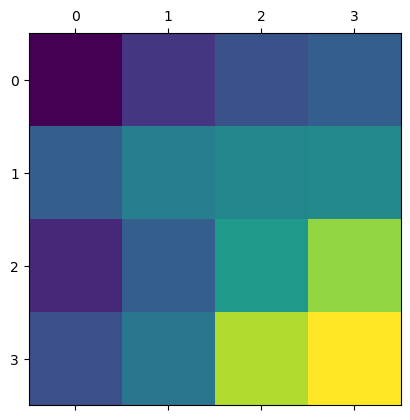

In [12]:
heatmap = np.maximum(heatmap,0)
print(heatmap)
heatmap /= np.max(heatmap)
heatmap -= 0.95
heatmap *= 20
plt.matshow(heatmap)

In [13]:
heatmap_1 = heatmap

[[-0.44911623 -0.2177155  -0.09012103 -0.01503944]
 [-0.01541018  0.17312288  0.21628857  0.23237824]
 [-0.28562784 -0.01478076  0.3327453   0.7663429 ]
 [-0.09539247  0.12202263  0.82773685  1.0000002 ]]
[[142 201 234 253]
 [253  44  55  59]
 [184 253  84 195]
 [232  31 211 255]]
1


C:\Users\Victor\AppData\Local\Temp\ipykernel_5128\995109100.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


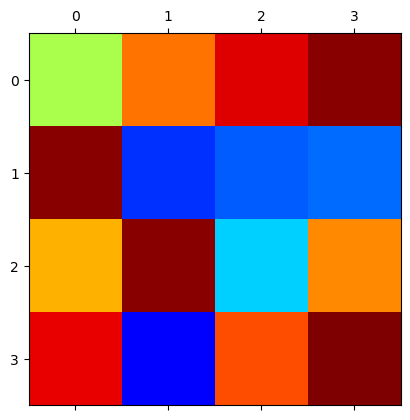

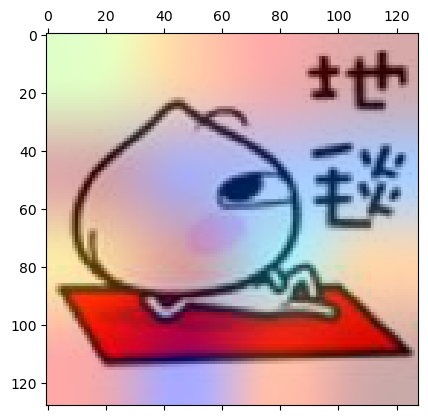

In [14]:
heatmap_1 = heatmap

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

print(heatmap_1)

heatmap_1 = np.uint8(255 * heatmap_1)

print(heatmap_1)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap_1]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)

save_path = "./heat_map/jet20230302t2131.jpg"
jet_heatmap.save(save_path)
plt.matshow(jet_heatmap)

jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))

save_path = "./heat_map/jet_sized20230302t2131.jpg"
jet_heatmap.save(save_path)

jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
plt.matshow(superimposed_img)
save_path = "./heat_map/20230302t2131.jpg"
superimposed_img.save(save_path)
print('1')